# Основной результат - наждение зависимости между настроением твитов про btc за день и ценой открытия на следующий день

In [1]:
import numpy as np
import pandas as pd

import os

from collections import defaultdict
import torch
from tqdm.notebook import tqdm


import torch
import torch.nn as nn

!pip -q install transformers

from transformers import BertModel

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 636 kB 53.4 MB/s 
     |████████████████████████████████| 3.3 MB 32.0 MB/s 
     |████████████████████████████████| 895 kB 67.8 MB/s 


# Для начала нужно научиться определять настроение, возьмем датасет Sentiment140, и проведем на нем файнтюнинг bert

## 1: Берем сантимет разметку твиттера из Sentiment140, это академический датасет твитов с таргетами настроения, он нам подходит

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!no | cp drive/MyDrive/ColabNotebooks/cmf/project2/Bitcoin_tweets.csv.zip Bitcoin_tweets.zip
# !no | cp drive/MyDrive/ColabNotebooks/cmf/project2/all_chats.csv.zip all_chats.zip
!no | cp drive/MyDrive/ColabNotebooks/cmf/project2/Sentiment140.zip Sentiment140.zip

!no | unzip Bitcoin_tweets.zip
# !no | unzip all_chats.zip
!no | unzip Sentiment140.zip

/bin/bash: no: command not found
/bin/bash: no: command not found
/bin/bash: no: command not found
Archive:  Bitcoin_tweets.zip
  inflating: Bitcoin_tweets.csv      
  inflating: __MACOSX/._Bitcoin_tweets.csv  
/bin/bash: no: command not found
Archive:  Sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df = df[['sentiment','text']].rename({'sentiment': 'target'}, axis=1)

df['target'] = df['target'].map({0: 0, 4:1})

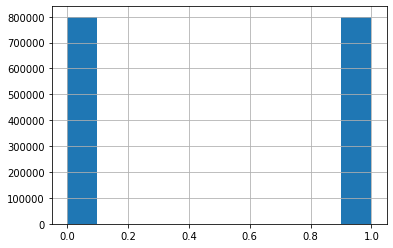

In [ ]:
# df = df.sample(100000)
df['target'].hist()

In [ ]:
df.head(2)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


## 2: Training/Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.target.values, 
                                                  test_size=0.15, 
                                                  random_state=42,
                                                  stratify=df.target.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.head()

,target,text,data_type
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",not_set
1,0,is upset that he can't update his Facebook by ...,not_set
2,0,@Kenichan I dived many times for the ball. Man...,not_set
3,0,my whole body feels itchy and like its on fire,not_set
4,0,"@nationwideclass no, it's not behaving at all....",not_set


In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['target', 'data_type']).count()

text
target data_type        
0      train      680000
       val        120000
1      train      680000
       val        120000

# 3. Загружаем Tokenizer и обрабатываем данные сами+берт

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

### немного специфично обработаем, удалим имена юзеров

In [ ]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = str.lower(str(text))

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-cased'
)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
preprocessed_train = df[df.data_type=='train']['text'].apply(lambda x: text_preprocessing(x)).values
preprocessed_val = df[df.data_type=='val']['text'].apply(lambda x: text_preprocessing(x)).values

In [ ]:
MAX_LEN = 64

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=preprocessed_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=MAX_LEN,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=preprocessed_val,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=MAX_LEN,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].target.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].target.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64
# Create the DataLoader for our training set
train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, 
    sampler=train_sampler, 
    batch_size=batch_size,
    num_workers=2
)


# Create the DataLoader for our validation set
val_data = TensorDataset(input_ids_val, attention_masks_val, labels_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(
    val_data, 
    sampler=val_sampler, 
    batch_size=batch_size,
    num_workers=2
)

# 4. Создаем классификатор на основе bert

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
device = torch.device("cuda")
# device = torch.device("cpu")
print(device)

cuda


In [ ]:
class SentimentClassifier(nn.Module):   
    def __init__(self, n_classes): 
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
model = SentimentClassifier(2)
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 5. Train

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    val_acc = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d[0].to(device)
            attention_mask = d[1].to(device)
            targets = d[2].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        val_acc = correct_predictions.double() / n_examples
        val_loss = np.mean(losses)
        print(f'Val accuracy {val_acc} Val loss {val_loss}')
    return correct_predictions.double() / n_examples, val_loss

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for ind, d in enumerate(data_loader):

        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        targets = d[2].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        if ind % 50 == 0: 
            print(f'Batch {ind} loss: {np.mean(losses)}')
        # if (ind + 1) % 50 == 0:
        #     eval_model(
        #         model,
        #         val_dataloader,
        #         loss_fn,
        #         device,
        #         len(val_data)
        #     )
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
print(len(train_dataloader))

EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

21250


In [ ]:
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_data)
    )

    eval_model(
        model,
        val_dataloader,
        loss_fn,
        device,
        len(val_data)
    )


    print(f'Train accuracy {train_acc} loss {train_loss} ')

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, f'drive/MyDrive/ColabNotebooks/cmf/project2/bert/bert_all_{epoch}_epoch_states')

model.eval()

### этот ноутбук я не стал перезапускать - долго. За две эпохи получили примерно 88% accuracy

# Теперь у нас есть модель которой можно разметить твиты, давайте разметим их

# 6. Размечаем новые данные

In [ ]:
# переопределим чтобы можно было запускать отсюда
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from collections import defaultdict
import torch
from tqdm.notebook import tqdm

import torch.nn as nn

!pip -q install transformers

!pip -q install googletrans==3.1.0a0

from transformers import BertModel


from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from googletrans import Translator
from datetime import datetime

tokenizer = BertTokenizer.from_pretrained(
    'bert-base-cased'
)

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

MAX_LEN = 64

device = 'cuda'

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 28.9 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Сверху скопировал
class SentimentClassifier(nn.Module):   
    def __init__(self, n_classes): 
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)



import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = str.lower(str(text))

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 7. Определяем модель, делаем скор

In [ ]:
model = SentimentClassifier(2)
model.load_state_dict(torch.load('drive/MyDrive/ColabNotebooks/cmf/project2/bert/bert_all_1_epoch_states')['state_dict'])
model.eval()
model.to(device)
print('')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!no | cp drive/MyDrive/ColabNotebooks/cmf/project2/Bitcoin_tweets.csv.zip Bitcoin_tweets.zip

!no | unzip Bitcoin_tweets.zip

/bin/bash: no: command not found
/bin/bash: no: command not found
Archive:  Bitcoin_tweets.zip
  inflating: Bitcoin_tweets.csv      
replace __MACOSX/._Bitcoin_tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [ ]:
new_data = pd.read_csv('Bitcoin_tweets.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
len(new_data)

1232809

In [ ]:
new_data['text'][:3]

0    Blue Ridge Bank shares halted by NYSE after #b...
1    😎 Today, that's this #Thursday, we will do a "...
2    Guys evening, I have read this article about B...
Name: text, dtype: object

In [ ]:
preprocessed_test = new_data['text'].apply(text_preprocessing)

In [ ]:
preprocessed_test[:5]

0    blue ridge bank shares halted by nyse after #b...
1    😎 today, that's this #thursday, we will do a "...
2    guys evening, i have read this article about b...
3    $btc a big chance in a billion! price: \487264...
4    this network is secured by 9 508 nodes as of t...
Name: text, dtype: object

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=preprocessed_test,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=MAX_LEN,
    return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64
# Create the DataLoader for our training set
test_data = TensorDataset(input_ids_test, attention_masks_test)
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=2
)

In [ ]:
with torch.no_grad():
    prediction = torch.tensor([], device=device)
    score = torch.tensor([], device=device)

    for d in tqdm(test_dataloader):
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # _, preds = torch.max(outputs, dim=1)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        # prediction = torch.cat((prediction, preds))
        score = torch.cat((score, probs))


  0%|          | 0/19263 [00:00<?, ?it/s]

In [ ]:
new_data['score'] = score.cpu().detach().numpy()

In [ ]:
new_data.head(2)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,0.018617
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,0.986063


In [ ]:
new_data.to_csv('drive/MyDrive/ColabNotebooks/cmf/project2/all_bert_all_2epoch.csv', index=False)

In [ ]:
pd.read_csv('drive/MyDrive/ColabNotebooks/cmf/project2/all_bert_all_2epoch.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,score
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,0.018617
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,0.986063
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,0.995640
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,0.474543
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False,0.547838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232804,Angela,"Brighton East, Victoria",Be careful. The devil has a pretty face. 😈 #Bi...,2009-05-21 02:14:09,78.0,1206,4802,False,2021-09-10 21:15:34,@SpeedUpBSC @debi_pada @AdaTiers @golf_grinder...,"['BTC', 'BSCGems', 'BNB', 'SpeeeUpBSC', 'Airdr...",AngelaAngela,False,0.603228
1232805,Mike Smith,"London, England",NaN,2021-09-08 21:35:25,0.0,24,2,False,2021-09-10 21:15:33,"This time, what will happen between the US SEC...","['BTC', 'ETH', 'Coinbase', 'SEC']",Twitter Web App,False,0.792346
1232806,CryptoMatic 💫,NaN,crypto market analyst 📈📊📉\nDM for business!! 🤝...,2020-07-27 10:02:22,292.0,161,14780,False,2021-09-10 21:15:04,One #btc is only 205 #EGLD.,"['btc', 'EGLD']",Twitter for Android,False,0.172582
1232807,OC34N,San Diego,♤♡◇♧\nPatriot\nCreator\njoin new Discord tradi...,2012-08-08 03:25:50,34.0,263,826,False,2021-09-10 21:14:46,Want to join a group that posted TSLA 745P day...,"['TSLA', 'AMC', 'GME', 'WISH', 'BBIG', 'AMZN',...",Twitter Web App,False,0.935888
